# Compare Atomic Files

This notebook shows how to compare the `levels_prepared` and `lines_prepared` DataFrames of the atomic files generated by Carsus.

In [3]:
import os
import pandas as pd
import numpy as np
import logging
from carsus.util import parse_selected_species, convert_symbol2atomic_number, convert_atomic_number2symbol
from collections import defaultdict
from carsus.io.nist import NISTWeightsComp, NISTIonizationEnergies
from carsus.io.kurucz import GFALLReader
from carsus.io.zeta import KnoxLongZeta
from carsus.io.chianti_ import ChiantiReader
from carsus.io.output import TARDISAtomData
from collections import defaultdict


In [4]:
logger = logging.getLogger(__name__)

In [5]:
ATOM1_PATH = os.environ.get("ATOM1_PATH", None)
ATOM2_PATH = os.environ.get("ATOM2_PATH", None)

Define the following functions to compare both dataframes.

In [7]:
def highlight_values(val):
    if val == True:
        return 'background-color: #BCF5A9'
    else:
        return 'background-color: #F5A9A9'
    
def highlight_diff(val):
    if val == 0:
        return 'background-color: #BCF5A9'
    else:
        return 'background-color: #F5A9A9'

In [56]:
from curses import keyname
from webbrowser import get


class AtomDataCompare:
    def __init__(self, d1_path=None, d2_path=None):
        self.d1_path = d1_path
        self.d2_path = d2_path
        self.setup()
        self.level_columns = ["energy", "g", "metastable"]  # TODO: for all dataframes

    def set_keys_as_attributes(self, alt_keys={}):
        # alt keys should be a subset of this dict
        # other keys would be ignored
        alt_keys_default = {
            "lines": ["lines_data", "lines"],
            "levels": ["levels_data", "levels"],
            "collisions": ["collisions_data", "collision_data"],
            "photoionization_data": ["photoionization_data"],
        }
        alt_keys_default = defaultdict(list, alt_keys_default)

        for key, val in alt_keys_default.items():
            if alt_keys.get(key, None):
                alt_keys_default[key].extend(alt_keys[key])

            for item in val:
                if self.d1.get_node(item):
                    setattr(self, key + "1", self.d1[item])
                if self.d2.get_node(item):
                    setattr(self, key + "2", self.d2[item])

    def setup(self):
        self.d1 = pd.HDFStore(self.d1_path)
        self.d2 = pd.HDFStore(self.d2_path)

    def teardown(self):
        self.d1.close()
        self.d2.close()

    def comparision_table(self):
        d1_keys = self.d1.keys()
        d2_keys = self.d2.keys()
        self.d1_df = pd.DataFrame(index=d1_keys, columns=["exists"])
        self.d2_df = pd.DataFrame(index=d2_keys, columns=["exists"])
        self.d1_df["exists"] = True
        self.d2_df["exists"] = True
        joined_df = self.d1_df.join(self.d2_df, how="outer", lsuffix="_1", rsuffix="_2")
        joined_df = joined_df.fillna(False)
        self.tt = joined_df

    @property
    def tt_stylized(self):
        return self.tt.style.applymap(
            highlight_values, subset=["exists_1", "exists_2", "match"]
        )

    def compare(self, exclude_correct_matches=True):
        self.tt["match"] = None
        for index, row in self.tt.iterrows():
            if row[["exists_1", "exists_2"]].all():
                row1_df = self.d1[index]
                row2_df = self.d2[index]
                if row1_df.equals(row2_df):
                    self.tt.at[index, "match"] = True
                else:
                    self.tt.at[index, "match"] = False
            else:
                self.tt.at[index, "match"] = False

        if exclude_correct_matches:
            self.tt = self.tt[self.tt.match == False]

    def diff(self, key_name, ion, rtol=1e-07, simplify_output=True):
        # Ion differences

        try:
            df1 = getattr(self, key_name + "1")
            df2 = getattr(self, key_name + "2")
        except AttributeError as exc:
            raise Exception(
                f"Either keyname: {keyname} is invalid or keys are not set."
                "Please use the set_keys_as_attributes method to set keys as attributes for comparision."
            )

        # TODO: should this be moved somewhere else?
        species1 = df1.index.get_level_values("atomic_number")
        species1 = set([convert_atomic_number2symbol(item) for item in species1])
        
        species2 = df2.index.get_level_values("atomic_number")
        species2 = set([convert_atomic_number2symbol(item) for item in species2])
        
        species_diff = species1.symmetric_difference(species2)
        if len(species_diff):
            print(f"Elements not in common in both dataframes: {species_diff}" )
        

        common_columns = df2.columns.intersection(df1.columns)
        if common_columns.empty:
            raise ValueError("There are no common columns for comparison. Exiting.")

        mismatched_cols = df2.columns.symmetric_difference(df1.columns)
        if not mismatched_cols.empty:
            logger.warning("Columns do not match.")
            logger.warning(f"Mismatched columns: {mismatched_cols}")
            logger.info(f"Using common columns for comparision:{common_columns}")

        if df1.index.names != df2.index.names:
            raise ValueError("Index names do not match.")

        setattr(self, f"{key_name}_" + "columns", common_columns)
        parsed_ion = parse_selected_species(ion)[0]

        try:
            df1 = df1.loc[parsed_ion]
            df2 = df2.loc[parsed_ion]
        except KeyError as exc:
            raise Exception(
                "The element does not exist in one of the dataframes."
            ) from exc

        merged_df = pd.merge(
            df1,
            df2,
            left_index=True,
            right_index=True,
            suffixes=["_1", "_2"],
        )

        non_numeric_cols = ["line_id", "metastable"]
        common_cols_rearranged = []

        for item in common_columns:
            if item in non_numeric_cols:
                merged_df["matches_" + item] = (
                    merged_df[item + "_1"] == merged_df[item + "_2"]
                )
                common_cols_rearranged.extend(
                    [
                        item + "_1",
                        item + "_2",
                        "matches_" + item,
                    ]
                )
            else:
                merged_df["matches_" + item] = np.isclose(
                    merged_df[item + "_1"], merged_df[item + "_2"], rtol=rtol
                )
                merged_df["pct_change_" + item] = merged_df[
                    [item + "_1", item + "_2"]
                ].pct_change(axis=1)[item + "_2"]

                merged_df["pct_change_" + item] = merged_df[
                    "pct_change_" + item
                ].fillna(0)

                common_cols_rearranged.extend(
                    [item + "_1", item + "_2", "matches_" + item, "pct_change_" + item]
                )

        merged_df = merged_df[common_cols_rearranged]
        merged_df = merged_df.sort_values(by=merged_df.index.names, axis=0)

        setattr(self, "merged_" + key_name + "_" + ion, merged_df)

        if simplify_output:
            return self.simplified_df(merged_df)

        return merged_df

    def simplified_df(self, df):
        df_simplified = df.drop(df.filter(regex="_1$|_2$").columns, axis=1)
        return df_simplified

    def style_df(self, key_name, ion, simplify_df=True):
        df_name_format = "merged_{}_".format(key_name)  # TODO

        if hasattr(self, df_name_format + ion):
            merged_df = getattr(self, df_name_format + ion)
        else:
            merged_df = self.diff(key_name=key_name, ion=ion)
            
        columns = getattr(self, f"{key_name}_" + "columns")
        subset = ["matches_" + item for item in columns]
        if simplify_df:
            merged_df = self.simplified_df(merged_df)

        return merged_df.style.applymap(highlight_values, subset=[*subset])


In [57]:
pat = "/home/atharva/workspace/code/tardis-main/carsus/kurucz_cd23_chianti_He_cmfgen_H_Si_I-II.h5"
pat2 = "/home/atharva/workspace/code/tardis-main/refdata/atom_data/kurucz_cd23_chianti_H_He.h5"
atc = AtomDataCompare(pat, pat2)
atc.setup()
atc.comparision_table()
atc.compare()
atc.set_keys_as_attributes()
# atc.teardown()
atc.tt

,exists_1,exists_2,match
/atom_data,True,True,False
/collision_data,False,True,False
/collision_data_temperatures,False,True,False
/collisions_data,True,False,False
/collisions_metadata,True,False,False
/ionization_data,True,True,False
/levels,False,True,False
/levels_data,True,False,False
/lines,False,True,False
/lines_data,True,False,False


In [58]:
atc.set_keys_as_attributes()

In [59]:
atc.style_df(key_name="lines", ion="He")

[                py.warnings][WARNING] - /home/atharva/miniconda3/envs/carsus-devel/lib/python3.7/site-packages/ipykernel_launcher.py:115: PerformanceWarning: indexing past lexsort depth may impact performance.
 (warnings.py:110)
[                py.warnings][WARNING] - /home/atharva/miniconda3/envs/carsus-devel/lib/python3.7/site-packages/ipykernel_launcher.py:116: PerformanceWarning: indexing past lexsort depth may impact performance.
 (warnings.py:110)


In [21]:
atc.merged_lines_He

,,line_id_1,line_id_2,matches_line_id,wavelength_1,wavelength_2,matches_wavelength,pct_change_wavelength,f_ul_1,f_ul_2,matches_f_ul,...,matches_B_lu,pct_change_B_lu,B_ul_1,B_ul_2,matches_B_ul,pct_change_B_ul,A_ul_1,A_ul_2,matches_A_ul,pct_change_A_ul
level_number_lower,level_number_upper,,,,,,,,,,,,,,,,,,,,,
1,34,533215,533180,False,2945.965,2945.970,False,0.000002,0.003800,0.003800,True,...,False,0.000002,1.879519e+08,1.879522e+08,False,0.000002,2.920590e+06,2.920581e+06,False,-0.000003
5,31,533246,533211,False,4122.154,4122.162,False,0.000002,0.001217,0.001217,True,...,False,0.000002,8.420373e+07,8.420390e+07,False,0.000002,4.776012e+05,4.775993e+05,False,-0.000004
10,17,533279,533244,False,21125.883,21125.922,False,0.000002,0.145000,0.145000,True,...,False,0.000002,5.143022e+10,5.143032e+10,False,0.000002,2.167108e+06,2.167100e+06,False,-0.000004
27,46,533368,533340,False,40490.092,40490.167,False,0.000002,0.000571,0.000571,True,...,False,0.000002,3.882657e+08,3.882664e+08,False,0.000002,2.323750e+03,2.323742e+03,False,-0.000004
4,36,533240,533205,False,4027.336,4027.344,False,0.000002,0.021400,0.021400,True,...,False,0.000002,1.446995e+09,1.446998e+09,False,0.000002,8.800762e+06,8.800727e+06,False,-0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,38,533247,533212,False,4027.495,4027.502,False,0.000002,0.015800,0.015800,True,...,False,0.000002,1.068385e+09,1.068386e+09,False,0.000002,6.497246e+06,6.497223e+06,False,-0.000003
12,26,533291,533256,False,18690.450,18690.484,False,0.000002,0.081143,0.081143,True,...,False,0.000002,2.546276e+10,2.546281e+10,False,0.000002,1.549362e+06,1.549357e+06,False,-0.000004
0,48,533204,533169,False,515.617,515.618,False,0.000002,0.005100,0.005100,True,...,False,0.000002,4.415022e+07,4.415031e+07,False,0.000002,1.279552e+08,1.279547e+08,False,-0.000004


In [63]:
atc.diff(key_name="collisions", ion='He')

Elements not in common in both dataframes: {'H'}


matches_g_ratio  pct_change_g_ratio  \
level_number_lower level_number_upper                                        
0                  1                              True                 0.0   
                   2                              True                 0.0   
                   3                              True                 0.0   
                   4                              True                 0.0   
                   5                              True                 0.0   
...                                                ...                 ...   
5                  44                             True                 0.0   
                   45                             True                 0.0   
                   46                             True                 0.0   
                   47                             True                 0.0   
                   48                             True                 0.0   

                                       matches_delta_e  pct_change_delta_e  \
level_number_lower level_number_upper                                        
0                  1                             False       -2.737351e-07   
                   2                             False       -2.737351e-07   
                   3                             False       -2.737351e-07   
                   4                             False       -2.737351e-07   
                   5                             False       -2.737351e-07   
...                                                ...                 ...   
5                  44                            False       -2.737351e-07   
                   45                            False       -2.737351e-07   
                   46                            False       -2.737351e-07   
                   47                            False       -2.737351e-07   
                   48                            False       -2.737351e-07   

                                       matches_t002000  pct_change_t002000  \
level_number_lower level_number_upper                                        
0                  1                              True        6.896128e-11   
                   2                              True        8.142953e-11   
                   3                              True        1.510609e-10   
                   4                              True        1.175131e-10   
                   5                              True        1.210529e-10   
...                                                ...                 ...   
5                  44                             True       -1.414313e-12   
                   45                             True       -1.408873e-12   
                   46                             True       -1.411760e-12   
                   47                             True       -5.384804e-12   
                   48                             True        5.405676e-12   

                                       matches_t004000  pct_change_t004000  \
level_number_lower level_number_upper                                        
0                  1                              True        1.378937e-10   
                   2                              True        1.628218e-10   
                   3                              True        3.020175e-10   
                   4                              True        2.349609e-10   
                   5                              True        2.420368e-10   
...                                                ...                 ...   
5                  44                             True       -2.828404e-12   
                   45                             True       -2.818301e-12   
                   46                             True       -2.823852e-12   
                   47                             True       -1.076972e-11   
                   48                             True    

In [44]:
atc.diff(key_name="lines", ion='H', simplify_output=False)

[                py.warnings][WARNING] - /home/atharva/miniconda3/envs/carsus-devel/lib/python3.7/site-packages/ipykernel_launcher.py:150: PerformanceWarning: indexing past lexsort depth may impact performance.
 (warnings.py:110)
[                py.warnings][WARNING] - /home/atharva/miniconda3/envs/carsus-devel/lib/python3.7/site-packages/ipykernel_launcher.py:151: PerformanceWarning: indexing past lexsort depth may impact performance.
 (warnings.py:110)


,,line_id_1,line_id_2,matches_line_id,wavelength_1,wavelength_2,matches_wavelength,pct_change_wavelength,f_ul_1,f_ul_2,matches_f_ul,...,matches_B_lu,pct_change_B_lu,B_ul_1,B_ul_2,matches_B_ul,pct_change_B_ul,A_ul_1,A_ul_2,matches_A_ul,pct_change_A_ul
level_number_lower,level_number_upper,,,,,,,,,,,,,,,,,,,,,
13,22,533751,533156,False,283800.00,40522.816,False,-0.857213,0.003159,0.636250,False,...,False,13.208865,1.505021e+10,4.328754e+11,False,27.762078,2.615846e+02,2.584466e+06,False,9879.036662
5,9,533582,533118,False,51272.60,18756.043,False,-0.634190,0.014537,0.161500,False,...,False,0.463060,1.251381e+10,5.085683e+10,False,3.064055,3.688420e+04,3.062191e+06,False,82.021763
7,21,533639,533137,False,67226.32,12821.615,False,-0.809277,0.000281,0.104500,False,...,False,13.062020,3.173019e+08,2.249544e+10,False,69.896018,4.149172e+02,4.240070e+06,False,10218.076058
2,18,533516,533102,False,8413.32,4341.661,False,-0.483954,0.000021,0.013975,False,...,False,16.250915,2.944398e+06,1.018693e+09,False,344.976675,1.964269e+03,4.945181e+06,False,2516.568411
15,20,533778,533160,False,556300.00,40522.945,False,-0.927156,0.024718,0.011833,False,...,False,-0.984817,2.308615e+11,8.050885e+09,False,-0.965127,5.327594e+02,4.806703e+04,False,89.222776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,7,533478,533104,False,3889.05,6564.536,False,0.687954,0.000502,0.347500,False,...,False,144.984053,3.279435e+07,3.829961e+10,False,1166.872421,2.215007e+05,5.378844e+07,False,241.836435
0,9,533452,533093,False,920.96,972.539,False,0.056006,0.000016,0.009650,False,...,False,5.349194,2.481712e+05,1.575687e+08,False,633.919355,1.262222e+05,6.805429e+07,False,538.162603
11,20,533716,533150,False,194900.00,40522.562,False,-0.792085,0.002555,0.365000,False,...,False,13.547383,8.360949e+09,2.483278e+11,False,28.700906,4.486698e+02,1.482659e+06,False,3303.566560


In [103]:
atc.diff(key_name="levels", ion='H')

,matches_energy,pct_change_energy,matches_g,pct_change_g,matches_metastable
level_number,,,,,
0,True,0.000000,True,0.000000,True
1,False,-0.000002,False,-0.750000,True
2,False,-0.156252,False,-0.888889,False
3,False,-0.199998,False,-0.875000,True
4,False,-0.074075,False,-0.960000,True
5,False,-0.085715,False,-0.972222,True
6,False,-0.092592,False,-0.959184,True
7,False,-0.097001,False,-0.968750,True
8,False,-0.099999,False,-0.962963,True


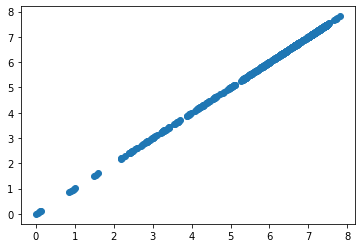

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(atc.merged_levels.energy_2, atc.merged_levels.energy_1,)

In [54]:
np.testing.assert_allclose(atc.d1['lines_data'].loc[(3,0,)]['line_id'].values, atc.d1['lines_data'].loc[(3,0,)]['line_id'].unique())

[                py.warnings][WARNING] - /home/atharva/miniconda3/envs/carsus-devel/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.
 (warnings.py:110)


fractional difference between energy
energy vs energy


In [ ]:
atc.d1['lines_data']

In [ ]:
atc.d1['collisions_data']

In [ ]:
atc.d2['collisions_data']

In [ ]:
atc.d2['lines']

In [ ]:
# concat = pd.concat([atc.d1['ionization_data'].rename("d1_ion"), atc.d2['ionization_data'].rename("d2_ion")], axis=1)

In [ ]:
def compare_levels_lines(path_a, path_b, ions='H-Zn'):
    
    # Read data
    levels_a = pd.read_hdf(path_a, key='levels_data')
    levels_b = pd.read_hdf(path_b, key='levels_data')
    lines_a = pd.read_hdf(path_a, key='lines_data')
    lines_b = pd.read_hdf(path_b, key='lines_data')
    
    # Get ions list
    ions = parse_selected_species(ions)
    
    lvl_eq = []
    lns_eq = []
    for ion in ions:
        
        # How many levels per ion in A
        try:
            num_lvl_a = len(levels_a.loc[ion])
            
        except (KeyError, TypeError, ValueError):
            num_lvl_a = 0
            
        # How many levels per ion in B
        try:
            num_lvl_b = len(levels_b.loc[ion])
            
        except (KeyError, TypeError, ValueError):
            num_lvl_b = 0

        # If level number is the same in A and B (and not zero) 
        # then compare cell against cell. `True` means all cells 
        # are equal in both dataframes.
        if num_lvl_a == num_lvl_b:
            val_lvl = True
            
            if num_lvl_a != 0:
                try:
                    k = levels_a.loc[ion].eq(levels_b.loc[ion]).sum().sum()
                    if num_lvl_a*3 != k:  # x3 because this df has three columns!
                        val_lvl = False
                        
                except (KeyError, TypeError, ValueError):
                    pass

        else:
            val_lvl = False
            
        # Append the results
        lvl_eq.append((ion, num_lvl_a, num_lvl_b, val_lvl))
        
        
        # Same for lines
        try:
            num_lns_a = len(lines_a.loc[ion])
            
        except (KeyError, TypeError, ValueError):
            num_lns_a = 0
            
        try:
            num_lns_b = len(lines_b.loc[ion])
            
        except (KeyError, TypeError, ValueError):
            num_lns_b = 0

        if num_lns_a == num_lns_b:
            val_lns = True
            
            if num_lns_a != 0:
                try:
                    k = lines_a.loc[ion].eq(lines_b.loc[ion]).sum().sum()
                    if num_lns_a*8 != k:
                        val_lvl = False
            
                except (KeyError, TypeError, ValueError):
                    pass
            
        else:
            val_lns = False
        
        lns_eq.append((ion, num_lns_a, num_lns_b, val_lns))
            
    df_lvl = pd.DataFrame(lvl_eq, columns=['ion', 'num_lvl_a', 'num_lvl_b', 'val_lvl'])
    df_lns = pd.DataFrame(lns_eq, columns=['ion', 'num_lns_a', 'num_lns_b', 'val_lns'])
    df = pd.merge(df_lvl, df_lns).set_index('ion')
    
    df['diff_lvl'] = abs(df['num_lvl_b'] - df['num_lvl_a'])
    df['diff_lns'] = abs(df['num_lns_b'] - df['num_lns_a'])
    df = df[['num_lvl_a', 'num_lvl_b', 'diff_lvl', 'val_lvl', 
          'num_lns_a', 'num_lns_b', 'diff_lns', 'val_lns']]

    return df

### Custom Atomic Data

To generate and compare atomic data files locally, please uncomment the code below.<br>
For the first atomic file we grab species `H-C` from GFALL and `H-He` from Chianti.

In [ ]:
# atomic_weights = NISTWeightsComp()
# ionization_energies = NISTIonizationEnergies('H-C')
# gfall_reader = GFALLReader(ions='H-C')
# chianti_reader = ChiantiReader(ions='H-He', collisions=True, priority=20)
# zeta_data = KnoxLongZeta()

In [ ]:
# atom_data_a = TARDISAtomData(atomic_weights,
#                              ionization_energies,
#                              gfall_reader,
#                              zeta_data,
#                              chianti_reader)

In [ ]:
# atom_data_a.to_hdf('A.h5')

For the second atomic file we grab species `H-C` from GFALL and `C` from Chianti.

In [ ]:
# chianti_reader = ChiantiReader(ions='C', collisions=True, priority=20)

In [ ]:
# atom_data_b = TARDISAtomData(atomic_weights,
#                              ionization_energies,
#                              gfall_reader,
#                              zeta_data,
#                              chianti_reader)

In [ ]:
# atom_data_b.to_hdf('B.h5')

In [ ]:
# tt = compare_levels_lines('A.h5', 'B.h5', ions='H-C')

```
num_xxx_y (int) : number of levels/lines.
diff_xxx (int) : difference in number of levels/lines.
val_xxx (bool) : `True` if levels/lines have the same value.
```

In [ ]:
tt.style.applymap(highlight_values, subset=['val_lvl', 'val_lns']).applymap(
                    highlight_diff, subset=['diff_lvl', 'diff_lns'])